# Моделирование разрыва регрессии



Пусть есть потенциальные исходы $C_0$ и $C_1$. Тритмент $T$ это пороговая фунцкция некоторой *бегущей переменной* $R$ такой что
$T = I\{R>c\}$.

Иначе говоря, тритмент отсутствует, когда бегущая переменная ниже порогового значения.

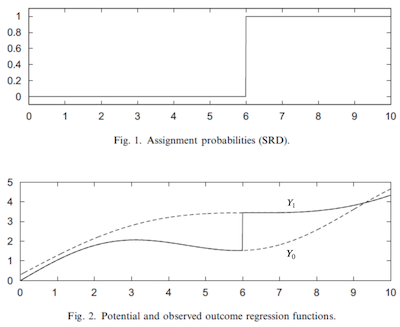


In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from joblib import Parallel, delayed

sns.set(font_scale=1.2, palette="Set2")


## Эффект от мин. возраста употребления алкоголя



Загрузим данные о смертности, агрегированные по возрасту. Каждая строка содержит:
* средний возраст группы людей
* среднюю смертность от всех причин (`all`)
* среднюю смертность в результате дорожно-транспортного происшествия (`mva`)
* среднюю смертность в результате самоубийства (`suicide`).

In [2]:
drinking = pd.read_csv("./drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


Централизуем исследуемую величину `agecell` по порогу 21

In [3]:
drinking["agecell"] -= 21

На графиках таргетов можно видеть некоторый скачок смертности по мере того, как мы достигаем установленного законом возраста употребления алкоголя.

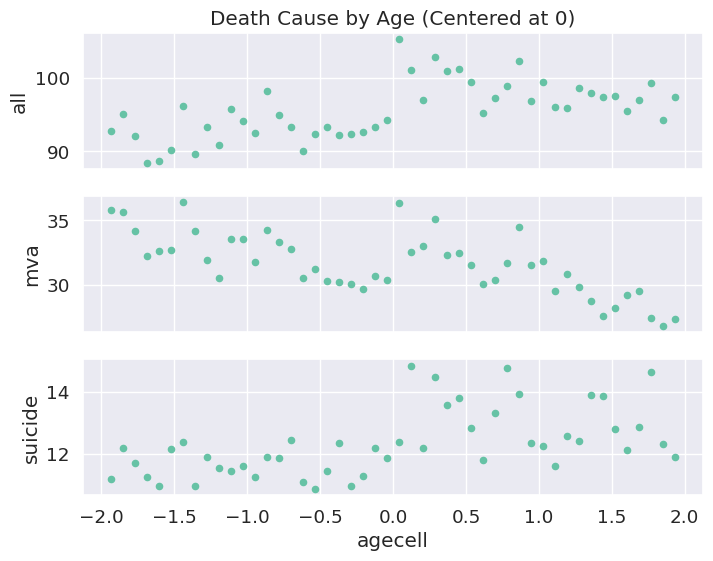

In [4]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(3, 1, 1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3, 1, 2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3, 1, 3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);


## RDD Estimation

Главное предположение оценки RDD: гладкость потенциальных исходов на пороговом уровне. Формально, пределы потенциальных исходов по мере приближения бегущей переменной к пороговому значению справа и слева должны быть одинаковыми.

$$
\lim_{r \to c^-} \mathsf{E}(C_{ti}|R_i=r) = \lim_{r \to c^+} \mathsf{E}(C_{ti}|R_i=r)
$$

В таком случае мы можем оценить причинно-следственный эффект

$$
\begin{align}
&\lim_{r \to c^+} \mathsf{E}(Y_{ti}|R_i=r) - \lim_{r \to c^-} \mathsf{E}(Y_{ti}|R_i=r) \\
=&\lim_{r \to c^+} \mathsf{E}(C_{1i}|R_i=r) - \lim_{r \to c^-} \mathsf{E}(C_{0i}|R_i=r) \\
=& \mathsf{E}(C_{1i}|R_i=r) - \mathsf{E}(C_{0i}|R_i=r) \\
=& \mathsf{E}(C_{1i} - C_{0i}|R_i=r)
\end{align}
$$

Это своего рода Local Average Treatment Effect (LATE), поскольку мы можем узнать его только на пороге.


Для оценки такого эффекта построим регрессиию

$
y_i = \theta_0 + \theta_1 r_i + \theta_2 I\{r_i>c\} + \theta_3 I\{r_i>c\} r_i
$

По сути те самым мы обучим две отдельных регрессии: до порога и после порога. Но используя такую форму мы получаем, что
* $\theta_0$ &mdash; среднее до достижения порога
* $\theta_0+\theta_2$ &mdash; среднее после достижения порога

Вспомним, что мы центрировали бегущую переменную по пороговому значению. Тем самым, оказывается, что 
* $\theta_0$ &mdash; значение в момент порога для левой регрессии, то есть предел слева
* $\theta_0+\theta_2$ &mdash; значение в момент порога для правой регрессии, то есть предел справа


Тем самым, мы можем получить, что

$$
\lim_{r \to c^+} \mathsf{E}(Y_{ti}|R_i=r) - \lim_{r \to c^-} \mathsf{E}(Y_{ti}|R_i=r)=\beta_2=\mathsf{E}(ATE|R=c)
$$

Построим такую регрессию

In [5]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.ols("all ~ agecell*threshold", rdd_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


Получаем, что смертность увеличивается на 7.6627 пункта при употреблении алкоголя. Кроме того, такая модель позволяет оценить стат. значимость полученного результата.

Визуализация

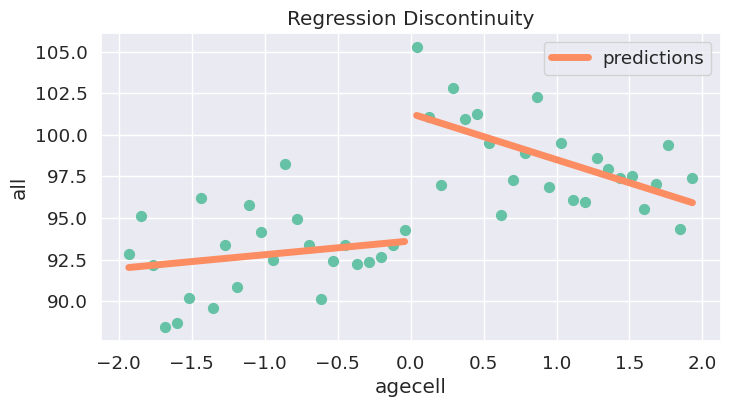

In [6]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0", s=50, figsize=(8, 4))
drinking.assign(predictions=model.fittedvalues).plot(
    x="agecell", y="predictions", ax=ax, color="C1", lw=5
)
plt.title("Regression Discontinuity");

Аналогично можем посмотреть на другие случаи

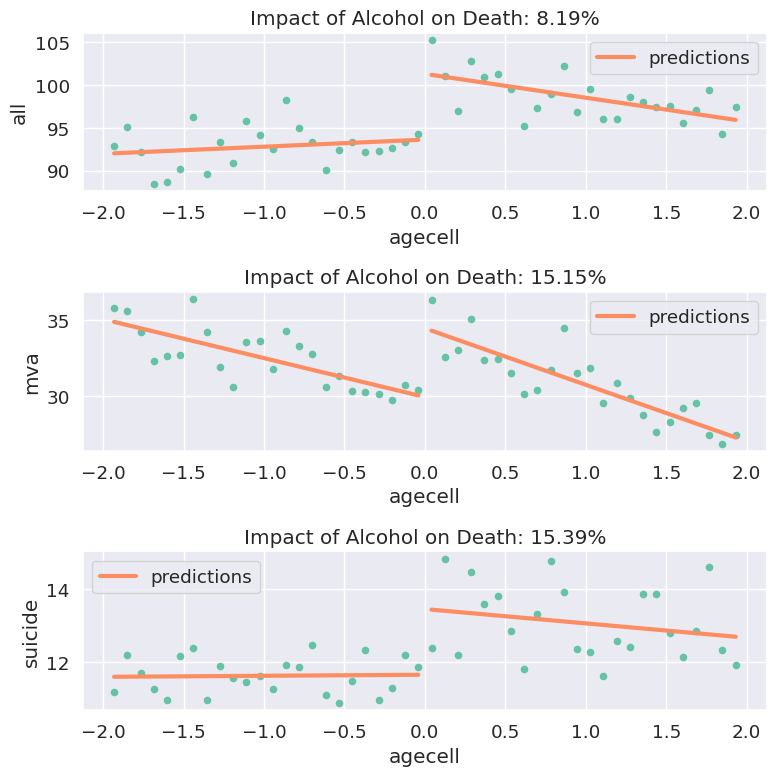

In [7]:
plt.figure(figsize=(8, 8))

for j, cause in enumerate(["all", "mva", "suicide"], 1):
    model = smf.ols(f"{cause} ~ agecell*threshold", rdd_df).fit()
    relative_ate = 100 * (
        (model.params["threshold"] + model.params["Intercept"])
        / model.params["Intercept"]
        - 1
    )

    ax = plt.subplot(3, 1, j)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    drinking.assign(predictions=model.fittedvalues).plot(
        x="agecell", y="predictions", ax=ax, color="C1", lw=3
    )
    plt.title(f"Impact of Alcohol on Death: {np.round(relative_ate, 2)}%")

plt.tight_layout()


### Ядерное взвешивание

Разрыв регрессии в значительной степени зависит от свойств экстраполяции линейной регрессии. 
Но поскольку мы смотрим только на значения в начале и конце двух линий регрессии, в первую очередь стоит наиболее точно определить эти пределы. 
Ведь иначе построенная модель может слишком сильно подогнаться по другим точкам, а значение около порога предсказывать плохо.


Один из способов решить эту проблему &mdash; присвоить более высокие веса точкам, которые расположены ближе к пороговому значению. Наиболее популярный способ &mdash; использование взвешенной линейной регрессии с весами, определяемыми треугольным ядром

In [8]:
def kernel(R, c, h):
    indicator = (np.abs(R - c) <= h).astype(float)
    return indicator * (1 - np.abs(R - c) / h)

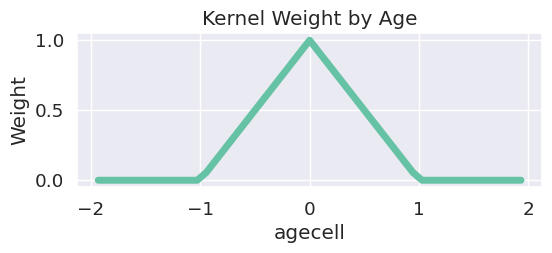

In [9]:
plt.figure(figsize=(6, 2))
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1), lw=5)
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

Применим такую регрессию, результат увеличился

In [10]:
weights = kernel(drinking["agecell"], c=0, h=1)

model = smf.wls("all ~ agecell*threshold", rdd_df, weights=weights).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


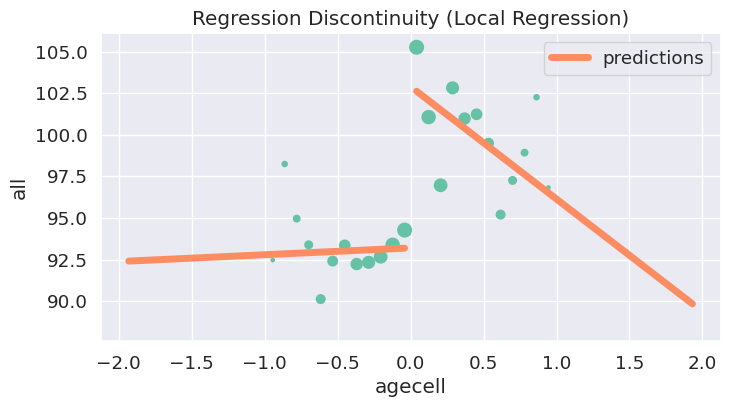

In [11]:
ax = drinking.plot.scatter(
    x="agecell", y="all", color="C0", s=100 * weights, figsize=(8, 4)
)
drinking.assign(predictions=model.fittedvalues).plot(
    x="agecell", y="predictions", ax=ax, color="C1", lw=5
)
plt.title("Regression Discontinuity (Local Regression)");

Аналогично для других случаев

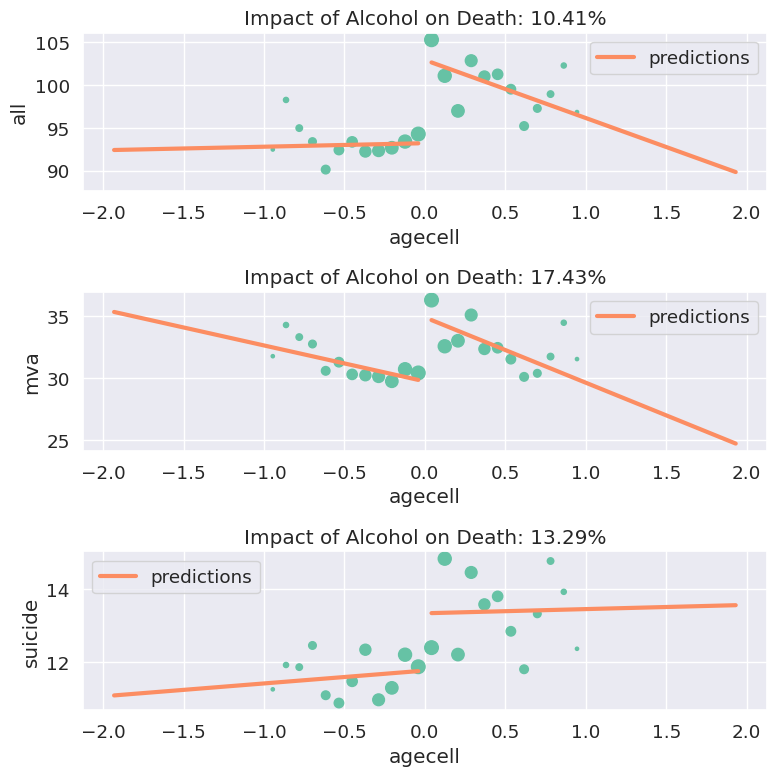

In [12]:
plt.figure(figsize=(8, 8))

for j, cause in enumerate(["all", "mva", "suicide"], 1):
    model = smf.wls(f"{cause} ~ agecell*threshold", rdd_df, weights=weights).fit()
    relative_ate = 100 * (
        (model.params["threshold"] + model.params["Intercept"])
        / model.params["Intercept"]
        - 1
    )

    ax = plt.subplot(3, 1, j)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax, s=100 * weights)
    drinking.assign(predictions=model.fittedvalues).plot(
        x="agecell", y="predictions", ax=ax, color="C1", lw=3
    )
    plt.title(f"Impact of Alcohol on Death: {np.round(relative_ate, 2)}%")

plt.tight_layout()